# Time Series - Statsmodels - 

https://machinelearningmastery.com/make-sample-forecasts-arima-python/ <br>

In [1]:
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #Graphics in SVG format are more sharp and legible
import scipy.sparse
import warnings
import random

In [2]:
plt.style.use('seaborn-white') #for jupyter dark, change style
sns.set_style("darkgrid")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import requests

print('Beginning file download with requests')

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
r = requests.get(url)

with open('data/austrialian_temprature_data.csv', 'wb') as series:
    series.write(r.content)

# Retrieve HTTP meta-data
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)

Beginning file download with requests
200
text/plain; charset=utf-8
utf-8


            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8
Index(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04', '1981-01-05',
       '1981-01-06', '1981-01-07', '1981-01-08', '1981-01-09', '1981-01-10',
       ...
       '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25', '1990-12-26',
       '1990-12-27', '1990-12-28', '1990-12-29', '1990-12-30', '1990-12-31'],
      dtype='object', name='Date', length=3650)


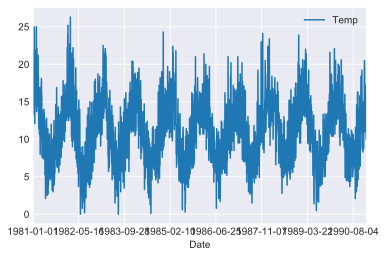

In [5]:
from statsmodels.tsa.arima_model import ARIMA
# load dataset
series = pd.read_csv('data/austrialian_temprature_data.csv', header=0, index_col=0)
# display first few rows
print(series.head())
print(series.index)
# line plot of dataset
series.plot()

 ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation.
 <br> 
 The predictors depend on the parameters (p,d,q) of the ARIMA model: <br>
Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).<br>
Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. <br>
Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

In [13]:
split_point = len(series) - 7
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
#dataset.to_csv('dataset.csv', index=False)
#validation.to_csv('validation.csv', index=False)

Dataset 3643, Validation 7


In [14]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)

In [15]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [16]:
# seasonal difference
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)

In [18]:
# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit(disp=0)

# print summary of fit model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3285
Model:                     ARMA(7, 1)   Log Likelihood               -8689.286
Method:                       css-mle   S.D. of innovations              3.408
Date:                Sun, 13 Oct 2019   AIC                          17398.571
Time:                        16:08:13   BIC                          17459.542
Sample:                             0   HQIC                         17420.401
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0149      0.132      0.113      0.910      -0.244       0.274
ar.L1.y        1.1436      0.287      3.983      0.000       0.581       1.706
ar.L2.y       -0.4355      0.154     -2.835      0.0

In [19]:
# one-step out of sample forecast

#The start and end can also be a datetime string or a “datetime” type; for example:
start_index = len(differenced)
end_index = len(differenced)
forecast = model_fit.predict(start=start_index, end=end_index) #forecast = model_fit.forecast()[0]

In [20]:
#Once made, we can invert the seasonal difference and convert the value back into the original scale.
# invert the differenced forecast to something usable

# invert the differenced forecast to something usable
forecast = inverse_difference(X, forecast, days_in_year)
print('Forecast: %f' % forecast)

Forecast: 14.872536


In [21]:
#The statsmodel ARIMA Results object also provides a predict() function for making forecasts to predict arbitrary in-sample and out-of-sample time steps, 
#The predict function requires a start and an end to be specified, 
#these can be the indexes of the time steps relative to the beginning of the training data used to fit the model, for example

# multi-step out-of-sample forecast
start_index = len(differenced)
end_index = start_index + 6
forecast = model_fit.predict(start=start_index, end=end_index) #forecast = model_fit.forecast(steps=7)[0]

In [22]:
#We can then invert each forecasted time step, one at a time and print the values. 
#Note that to invert the forecast value for t+2, we need the inverted forecast value for t+1.
#Here, we add them to the end of a list called history for use when calling inverse_difference().


# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Day 1: 14.872536
Day 2: 13.395909
Day 3: 15.723571
Day 4: 14.654407
Day 5: 14.475228
Day 6: 15.462977
Day 7: 16.531539
